# Trend Strategy 2

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.stats.multitest as mt
import arch.bootstrap as boot
import pyalgotrade.barfeed.csvfeed as csvfeed
import pyalgotrade.bar as bar
import pyalgotrade.strategy as strategy
import pyalgotrade.technical.macd as macd
import pyalgotrade.broker as broker
import pyalgotrade.stratanalyzer.returns as ret
import pyalgotrade.plotter as plotter
import datetime as dt
import itertools
import time

# Create Strategy Class

In [3]:
class TrendStrategy2(strategy.BacktestingStrategy):

    # 2.1. Define Strategy Initialization Function
    def __init__(self, feed, instrument, nfastEMA, nslowEMA, nsignalEMA):
        super(TrendStrategy2, self).__init__(feed, 10000)
        self.position = None
        self.instrument = instrument
        self.setUseAdjustedValues(True)
        self.macd = macd.MACD(feed[instrument].getPriceDataSeries(), nfastEMA, nslowEMA, nsignalEMA)

    # 2.2. Define Get Technical Indicators Functions
    def getMACD(self):
        return self.macd

    # 2.3. Define Overriding Strategy Functions

    # onEnterCanceled: Get notified when order submitted to enter a position was canceled and update position
    def onEnterCanceled(self, position):
        self.position = None

    # onExitOk: Get notified when order submitted to exit a position was filled and update position
    def onExitOk(self, position):
        self.position = None

    # onExitCanceled: Get notified when order submitted to exit a position was canceled and re-submit order
    def onExitCanceled(self, position):
         self.position.exitMarket()

    # 2.4. Define Trading Strategy Function

    # Trend-Following Momentum Strategy
    # Enter Long Order = Buy when MACD Histogram > 0,
    # Exit Order = Sell when MACD Histogram < 0

    def onBars(self, bars):
        if self.macd[-1] is None:
            return

        if self.position is None:
            if self.macd.getHistogram()[-1] > 0:
                # 95% equity investment for difference between order day Close price and next day Open price
                # number of shares can also be a fixed quantity for all transactions (ex. self.shares = 10)
                self.shares = int(self.getBroker().getCash() * 0.95 / bars[self.instrument].getPrice())
                self.position = self.enterLong(self.instrument, self.shares, goodTillCanceled=True)

        elif self.macd.getHistogram()[-1] < 0 and not self.position.exitActive():
            self.position.exitMarket()

### Define Run Strategy Function

In [5]:
def TrendStrategyRun2(nfastEMA, nslowEMA, nsignalEMA, chart):

    # 3.1. Create Instruments object with stock tickers
    instruments = ['SPY']

    # 3.2. Load CSV Feed previously downloaded or read
    feed = csvfeed.GenericBarFeed(bar.Frequency.DAY)
    feed.addBarsFromCSV(instruments[0], './Advanced-Trading-Analysis-Data.txt', skipMalformedBars=True)

    # 3.3. Evaluate Strategy with CSV Feed and Technical Indicator Parameters
    trendStrategy2 = TrendStrategy2(feed, instruments[0], nfastEMA, nslowEMA, nsignalEMA)

    # 3.4. Set Strategy Commission
    trendStrategy2.getBroker().setCommission(broker.backtesting.FixedPerTrade(6))

    # 3.5. Attach Strategy Trading Statistics Analyzers
    retAnalyzer = ret.Returns(maxLen=2518)
    trendStrategy2.attachAnalyzer(retAnalyzer)

    # 3.6. Attach Strategy Plotter
    plt = plotter.StrategyPlotter(trendStrategy2, plotPortfolio=False)
    plt.getOrCreateSubplot('MACD Hist').addDataSeries('MACD Hist', trendStrategy2.getMACD().getHistogram())
    plt.getOrCreateSubplot('MACD Hist').addLine('Center', level=0)

    # 3.7. Run Strategy
    trendStrategy2.run()

    # 3.8. Calculate Strategy Returns
    datesReturns = retAnalyzer.getReturns().getDateTimes()[:]
    dailyReturns = retAnalyzer.getReturns()[:]
    dailyReturns = pd.DataFrame(dailyReturns).set_index(pd.DatetimeIndex(datesReturns))

    # 3.9. Plot Strategy
    if chart == True:
        plt.plot(fromDateTime=dt.datetime(2016, 1, 1), toDateTime=dt.datetime(2016, 12, 31))

    return dailyReturns

##### Plot Strategy Example

C:\Users\evillarraga\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


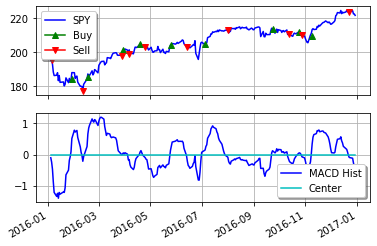

,0
2007-01-03,0.000000
2007-01-04,0.000000
2007-01-05,0.000000
2007-01-08,0.000000
2007-01-09,0.000000
2007-01-10,0.000000
2007-01-11,0.000000
2007-01-12,0.000000
2007-01-16,0.000000
2007-01-17,0.000000


In [6]:
TrendStrategyRun2(12, 26, 9, True)

### Do Strategy Parameters Optimization and Calculate Performance Metrics

In [7]:
# 4.1. Create Strategy Optimization Parameters Combinations
nfastEMA = (9, 12)
nslowEMA = (23, 26)
pool = [nfastEMA, nslowEMA]

In [9]:
# 4.2. Calculate Benchmark Daily Returns
# 100% equity investment for buy and hold benchmark
data = pd.read_csv('./Advanced-Trading-Analysis-Data.txt', index_col='Date Time', parse_dates=True)
trend2DailyReturns = data['Adj Close'].pct_change(1)
trend2DailyReturns[0] = 0
trend2DailyReturns = pd.DataFrame(trend2DailyReturns)

In [10]:
# 4.3. Do Strategy Optimization
trend2StartOptimization = time.time()
print('')
print('== Strategy Parameters Optimization ==')
print('')
print('Parameters Combinations (nfastEMA, nslowEMA):')
for n in itertools.product(*pool):
    print(n)
    trend2DailyReturns.insert(len(trend2DailyReturns.columns), n, TrendStrategyRun2(n[0], n[1], 9, False))
trend2EndOptimization = time.time()
trend2DailyReturns.columns = ['B&H', 'Tr2Ret1', 'Tr2Ret2', 'Tr2Ret3', 'Tr2Ret4']
print('')
print('Optimization Running Time: ', round(trend2EndOptimization - trend2StartOptimization, 4), ' seconds')
print('')


== Strategy Parameters Optimization ==

Parameters Combinations (nfastEMA, nslowEMA):
(9, 23)
(9, 26)
(12, 23)
(12, 26)

Optimization Running Time:  1.081  seconds



In [11]:
# 4.4. Define Cumulative Returns and Performance Metrics Functions
def CumulativeReturns(dailyReturns):
    cumulativeReturns = np.cumprod(dailyReturns + 1) ** (252 / len(dailyReturns)) - 1
    return cumulativeReturns

def PerformanceMetrics(dailyReturns):
    annualizedReturn = (np.cumprod(dailyReturns + 1) ** (252 / len(dailyReturns)) - 1)[-1]
    annualizedStdDev = np.std(dailyReturns) * np.sqrt(252)
    annualizedSharpe = annualizedReturn / annualizedStdDev
    return annualizedReturn, annualizedStdDev, annualizedSharpe

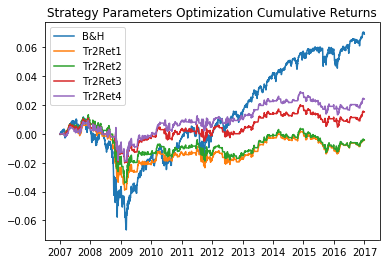

In [12]:
# 4.5. Chart Cumulative Returns Comparison
trend2CumulativeReturns = trend2DailyReturns.apply(CumulativeReturns, axis=0)
plt.plot(trend2CumulativeReturns['B&H'], label='B&H')
plt.plot(trend2CumulativeReturns['Tr2Ret1'], label='Tr2Ret1')
plt.plot(trend2CumulativeReturns['Tr2Ret2'], label='Tr2Ret2')
plt.plot(trend2CumulativeReturns['Tr2Ret3'], label='Tr2Ret3')
plt.plot(trend2CumulativeReturns['Tr2Ret4'], label='Tr2Ret4')
plt.title('Strategy Parameters Optimization Cumulative Returns')
plt.legend(loc='upper left')
plt.show()

In [13]:
# 4.6. Calculate Performance Metrics and Print Summary Table
trend2PerformanceMetrics = trend2DailyReturns.apply(PerformanceMetrics, axis=0)
trend2PerformanceSummary = [{'0': 'Annualized:', '1': 'B&H', '2': 'Tr2Ret1', '3': 'Tr2Ret2', '4': 'Tr2Ret3',
                             '5': 'Tr2Ret4'},
        {'0': 'Return',
         '1': np.round(trend2PerformanceMetrics[0][0], 4), '2': np.round(trend2PerformanceMetrics[1][0], 4),
         '3': np.round(trend2PerformanceMetrics[2][0], 4), '4': np.round(trend2PerformanceMetrics[3][0], 4),
         '5': np.round(trend2PerformanceMetrics[4][0], 4)},
        {'0': 'Standard Deviation',
         '1': np.round(trend2PerformanceMetrics[0][1], 4), '2': np.round(trend2PerformanceMetrics[1][1], 4),
         '3': np.round(trend2PerformanceMetrics[2][1], 4), '4': np.round(trend2PerformanceMetrics[3][1], 4),
         '5': np.round(trend2PerformanceMetrics[4][1], 4)},
        {'0': 'Sharpe Ratio (Rf=0%)',
         '1': np.round(trend2PerformanceMetrics[0][2], 4), '2': np.round(trend2PerformanceMetrics[1][2], 4),
         '3': np.round(trend2PerformanceMetrics[2][2], 4), '4': np.round(trend2PerformanceMetrics[3][2], 4),
         '5': np.round(trend2PerformanceMetrics[4][2], 4)}]
trend2PerformanceSummary = pd.DataFrame(trend2PerformanceSummary)
print('')
print('== Strategy Parameters Optimization Performace Summary ==')
print('')
print(trend2PerformanceSummary)
print('')


== Strategy Parameters Optimization Performace Summary ==

                      0       1        2        3        4        5
0           Annualized:     B&H  Tr2Ret1  Tr2Ret2  Tr2Ret3  Tr2Ret4
1                Return   0.069  -0.0045  -0.0042   0.0151   0.0241
2    Standard Deviation  0.2084   0.1172   0.1192   0.1132   0.1136
3  Sharpe Ratio (Rf=0%)  0.3309  -0.0384  -0.0354   0.1337   0.2119



### Do Multiple Hypothesis Testing P-Values Adjustments

In [14]:
# 5.1. Calculate Multiple Hypothesis Testing P-Values
trend2MultipleTTests = trend2DailyReturns.iloc[:, 1:5].apply(st.ttest_1samp, axis=0, popmean=0, nan_policy='omit')
trend2MultiplePValues = (trend2MultipleTTests[0][1], trend2MultipleTTests[1][1], trend2MultipleTTests[2][1],
                         trend2MultipleTTests[3][1])

In [15]:
# 5.2. Adjust Multiple Hypothesis Testing P-Values Calculations
trend2MultiplePValuesFWE = mt.multipletests(trend2MultiplePValues, alpha=0.05, method='bonferroni',
                                                   is_sorted=False, returnsorted=False)
trend2MultiplePValuesFDR = mt.multipletests(trend2MultiplePValues, alpha=0.05, method='fdr_bh',
                                                   is_sorted=False, returnsorted=False)

In [16]:
# 5.3. Print Multiple Hypothesis Testing P-Values Adjustment Summary Table
trend2MultiplePValuesSummary = [{'0': '', '1': 'Tr2Ret1', '2': 'Tr2Ret2', '3': 'Tr2Ret3', '4': 'Tr2Ret4'},
        {'0': 'PValues',
         '1': np.round(trend2MultiplePValues[0], 4), '2': np.round(trend2MultiplePValues[1], 4),
         '3': np.round(trend2MultiplePValues[2], 4), '4': np.round(trend2MultiplePValues[3], 4)},
        {'0': 'PValues FWE',
         '1': np.round(trend2MultiplePValuesFWE[1][0], 4), '2': np.round(trend2MultiplePValuesFWE[1][1], 4),
         '3': np.round(trend2MultiplePValuesFWE[1][2], 4), '4': np.round(trend2MultiplePValuesFWE[1][3], 4)},
        {'0': 'PValues FDR',
         '1': np.round(trend2MultiplePValuesFDR[1][0], 4), '2': np.round(trend2MultiplePValuesFDR[1][1], 4),
         '3': np.round(trend2MultiplePValuesFDR[1][2], 4), '4': np.round(trend2MultiplePValuesFDR[1][3], 4)}]
trend2MultiplePValuesSummary = pd.DataFrame(trend2MultiplePValuesSummary)
print('')
print('== Multiple Hypothesis Testing P-Values Adjustments ==')
print('')
print(trend2MultiplePValuesSummary)
print('')


== Multiple Hypothesis Testing P-Values Adjustments ==

             0        1        2        3        4
0               Tr2Ret1  Tr2Ret2  Tr2Ret3  Tr2Ret4
1      PValues   0.9487   0.9387   0.5493   0.3999
2  PValues FWE        1        1        1        1
3  PValues FDR   0.9487   0.9487   0.9487   0.9487



### Do Individual Time Series Bootstrap P-Value Multiple Comparison Adjustment

In [17]:
# 6.1. Define Bootstrap Mean Function
def bmean(x):
    return x.mean(0)

In [18]:
# 6.2. Do Individual Time Series Bootstrap
trend2StartBoot = time.time()
print('')
print('== Individual Time Series Bootstrap ==')
print('')
trend2Boot = boot.CircularBlockBootstrap(block_size=10, x=trend2DailyReturns.iloc[:, 4])
trend2BootMeans = trend2Boot.apply(func=bmean, reps=1000)
trend2BootIntervals = trend2Boot.conf_int(func=bmean, reps=1000, method='percentile', size=0.95, tail='two')
trend2EndBoot = time.time()
print('')
print('Bootstrap Running Time: ', round(trend2EndBoot - trend2StartBoot, 4), ' seconds')
print('')


== Individual Time Series Bootstrap ==


Bootstrap Running Time:  0.3209  seconds



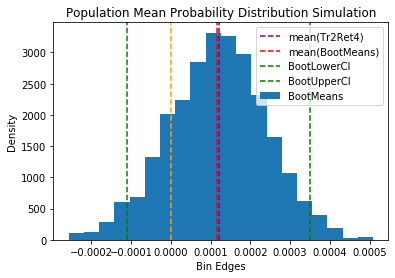

In [19]:
# 6.3. Chart Individual Time Series Bootstrap Histogram
plt.hist(trend2BootMeans, bins=20, density=True, label='BootMeans')
plt.title('Population Mean Probability Distribution Simulation')
plt.axvline(x=np.mean(trend2DailyReturns.iloc[:, 4]), color='purple', linestyle='--', label='mean(Tr2Ret4)')
plt.axvline(x=np.mean(trend2BootMeans), color='red', linestyle='--', label='mean(BootMeans)')
plt.axvline(x=0, color='orange', linestyle='--')
plt.axvline(x=trend2BootIntervals[0], color='green', linestyle='--', label='BootLowerCI')
plt.axvline(x=trend2BootIntervals[1], color='green', linestyle='--', label='BootUpperCI')
plt.ylabel('Density')
plt.xlabel('Bin Edges')
plt.legend(loc='upper right')
plt.show()

In [20]:
# 6.4. Calculate Individual Time Series Bootstrap P-Value
trend2BootPValue = 2 * min(np.mean(trend2BootMeans <= 0), np.mean(trend2BootMeans > 0))

In [21]:
# 6.5. Adjust Individual Time Series Bootstrap P-Value Calculation
trend2BootPValueFWE = 1 - (1 - trend2BootPValue) ** 4
print('')
print('== Individual Time Series Bootstrap Hypothesis Testing ==')
print('')
print('Tr2Ret4 P-Value:', np.round(trend2BootPValue, 4))
print('Tr2Ret4 P-Value FWE:', np.round(trend2BootPValueFWE, 4))


== Individual Time Series Bootstrap Hypothesis Testing ==

Tr2Ret4 P-Value: 0.36
Tr2Ret4 P-Value FWE: 0.8322
